based on https://arxiv.org/pdf/1611.01578.pdf

at every step, the RNN outputs two vectors, representing probability distributions for
 - type of layer: can be fully connected, skip connection, dropout, or end of network
 - argument for the layer: can be dropout probability, number of layers to skip (backwards), or number of neurons

In [104]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
import time

In [105]:
class ControllerRNN:
    def __init__(self, max_len, batch_size, type_size, arg_size,
                 learning_rate=0.001, hidden_size=32, baseline_smoothing=0.95):
        self.hidden_size = hidden_size
        self.unroll_by = max_len
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.type_size = type_size + 1  # 0 is for end-of-network token
        self.arg_size = arg_size
        self.baseline_smoothing = baseline_smoothing

    def build(self):
        # reward for the architectures
        self.architecture_reward = tf.placeholder(tf.float32, [self.batch_size])
        
        # exponential moving average of the reward
        self.last_average_reward = tf.reduce_mean(self.architecture_reward)
        self.reward_ema = tf.train.ExponentialMovingAverage(self.baseline_smoothing)
        self.update_reward_ema = self.reward_ema.apply([self.last_average_reward])

        rnn_input = tf.random_normal([self.batch_size, self.type_size + self.arg_size])
        rnn = tf.contrib.rnn.GRUCell(self.hidden_size)
        state = tf.random_normal([self.batch_size, rnn.state_size])

        # weight matrices to transform from rnn output to layer type and discrete arg
        rnn_to_layer_type_weight = tf.Variable(tf.random_normal([rnn.output_size + 1, self.type_size]))
        rnn_to_layer_type_gradient = []
        rnn_to_layer_arg_weight = tf.Variable(tf.random_normal([rnn.output_size + 1, self.arg_size]))
        rnn_to_layer_arg_gradient = []

        # layer_probs contains the output from the network, namely the probabilities
        # of type and argument for every layer of every network
        self.layer_probs = []

        # layer_indicators contains one-hot indicators of type and argument
        # for every layer of every network.
        # used to select which action is used to compute the gradient.
        # fixed, must be set before updating the weights
        self.layer_indicators = []

        losses = []
        for i in range(self.unroll_by):
            # run rnn cell
            output, state = rnn(rnn_input, state)

            if i == 0:  # rnn variables are only initialized now
                rnn_params = rnn.trainable_variables + rnn.trainable_weights
                rnn_gradients = [[] for _ in range(len(rnn_params))]

            # compute output probabilites
            output = tf.concat([output, tf.ones((output.shape[0], 1))], axis=1)
            layer_type = tf.nn.relu(tf.matmul(output, rnn_to_layer_type_weight))
            layer_arg = tf.nn.relu(tf.matmul(output, rnn_to_layer_arg_weight))
            rnn_input = tf.concat([layer_type, layer_arg], axis=1)

            layer_type_probs = tf.nn.softmax(layer_type)
            layer_arg_probs = tf.nn.softmax(layer_arg)

            chosen_layer_type = tf.placeholder(tf.int32, self.batch_size)
            chosen_layer_arg = tf.placeholder(tf.int32, self.batch_size)

            self.layer_probs.append((layer_type_probs, layer_arg_probs))
            self.layer_indicators.append((chosen_layer_type, chosen_layer_arg))

            # aggregate gradients
            baseline = self.reward_ema.average(self.last_average_reward)
            prob = (self.last_average_reward - baseline) * (
                tf.reduce_sum(
                    tf.one_hot(
                        chosen_layer_type, depth=self.type_size
                    ) * tf.log(layer_type_probs + 1e-12),
                    axis=1
                ) + tf.reduce_sum(
                    tf.one_hot(
                        chosen_layer_arg, depth=self.arg_size
                    ) * tf.log(layer_arg_probs + 1e-12),
                    axis=1
                )
            )
            losses.append(prob)

            rnn_to_layer_arg_gradient.append(tf.gradients(prob, rnn_to_layer_arg_weight)[0])
            rnn_to_layer_type_gradient.append(tf.gradients(prob, rnn_to_layer_type_weight)[0])
            for param, grad in zip(rnn_params, rnn_gradients):
                grad.append(tf.gradients(prob, param)[0])

        self.loss = tf.reduce_mean(losses)

        def sanitize_gradient(grads):
            avg = sum(grads) / len(grads)
            return tf.clip_by_norm(avg, 1.0)

        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.optimize = optimizer.apply_gradients([
            (sanitize_gradient(grad), param)
            for param, grad in zip(rnn_params, rnn_gradients)
        ] + [
            (sanitize_gradient(rnn_to_layer_type_gradient), rnn_to_layer_type_weight),
            (sanitize_gradient(rnn_to_layer_arg_gradient), rnn_to_layer_arg_weight),
        ])

    def generate_architecture(self, session):
        layers = session.run(self.layer_probs)
        networks = [[] for _ in range(self.batch_size)]
        for (ltype, larg) in layers:
            for i, (nnet, type_prob, arg_prob) in enumerate(zip(networks, ltype, larg)):
                # the network always has at least one layer
                if nnet and nnet[-1][0] == 0:
                    continue

                assert all(np.isfinite(type_prob))
                assert all(np.isfinite(arg_prob))

                if np.random.random() < 0.5:
                    layer_type = np.random.choice(len(type_prob), p=type_prob)
                    layer_arg = np.random.choice(len(arg_prob), p=arg_prob)
                else:
                    layer_type = np.argmax(type_prob)
                    layer_arg = np.argmax(arg_prob)

                nnet.append((layer_type, layer_arg))

        return networks

    def learn_from_rewards(self, sess, networks, rewards):
        assert len(rewards) == self.batch_size

        # set the indicator variables, telling which action was chosen
        feed_dict = {ind: []
                     for layer_ind in self.layer_indicators
                     for ind in layer_ind}

        for nnet in networks:
            # pad network if shorter than expected
            # we set the indicators to -1, so that all one hot will be 0
            # thus not contributing to the gradient
            if len(nnet) < self.unroll_by:
                nnet = nnet + [(-1, -1)] * (self.unroll_by - len(nnet))

            assert len(nnet) == self.unroll_by
            for (itype, iarg), (ntype, narg) in zip(self.layer_indicators, nnet):
                feed_dict[itype].append(ntype)
                feed_dict[iarg].append(narg)

        feed_dict[self.architecture_reward] = rewards
        loss, _, _ = sess.run([self.loss, self.update_reward_ema, self.optimize],
                              feed_dict=feed_dict)
        return loss

make a handy wrapper for this process

In [115]:
def run_rl_nas(spark_context, eval_fn, max_len, type_count,
               arg_count, max_steps=5000, end_fn=None,
               batch_size=1, controller_lr=0.001,
               hidden_size=32, baseline_smoothing=0.95):
    ''' run neural architecture search with reinforcement learning
        inspired by https://arxiv.org/abs/1611.01578
        
        every architecture is a list of layers, every layer is a tuple of
        two elements: the layer type and a numeric argument for the layer
        (both are integers). the interpretation of type and argument is
        up to you
        
        spark_context: if given, the evaluation function will be executed
                       on spark (one partition per architecture), otherwise
                       eval_fn will be called with *all* architectures

        eval_fn:       scores the given architecture(s). will be called for
                       each architecture if spark_context is given, otherwise
                       will be called with all architectures in a batch.
                       should return (list of) loss/error to be minimized

        max_len:       maximum length of the architectures to be generated
        
        batch_size:    how many architectures to generate in a single step
        
        type_count:    how many different types of layers to generate. an
                       additional type will be used to indicate the last
                       layer of the network (so the type will go from 0
                       to type_count, extremes included)
        
        arg_count:     how many possible layer arguments to generate
        
        max_steps:     maximum number of batches of networks to generate
        
        end_fn:        return True to stop training, False to continue,
                       None to stop if step >= max_steps
                       called with arguments (step number, architectures of
                       last batch, rewards of those architectures, controller
                       loss on last batch)
                       if given, takes precedence on max_steps, unless returns
                       None (useful e.g. to make loggers)
        
        controller_lr: learning rate to use to update the controller
        
        hidden_size:   number of hidden units to use in the controller gru
        
        baseline_smoothing: smoothing for the exponential moving average of
                       the baseline (see paper)
    '''
    
    if (max_steps is None or max_steps <= 0) and not hasattr(end_fn, '__call__'):
        raise ValueError('either max_steps or end_fn must be set')

    def score_archs(networks):
        if spark_context:
            return spark_context.parallelize(
                networks, len(networks)
            ).map(eval_fn).collect()
        else:
            return eval_fn(networks)

    controller = ControllerRNN(
        max_len=max_len,
        batch_size=batch_size,
        type_size=type_count,
        arg_size=arg_count,
        learning_rate=controller_lr,
        hidden_size=hidden_size,
        baseline_smoothing=baseline_smoothing,
    )
    
    controller_graph = tf.Graph()
    with controller_graph.as_default():
        controller.build()
        controller_session = tf.Session(  # a GPU is wasted for such a small network
            config=tf.ConfigProto(device_count={'GPU': 0}),
            graph=controller_graph
        )
        controller_session.run(tf.global_variables_initializer())

    step, done = 0, False
    while not done:
        networks = controller.generate_architecture(controller_session)
        rewards = score_archs(networks)
        loss = controller.learn_from_rewards(controller_session, networks, rewards)

        step += 1
        done = end_fn and end_fn(step, networks, rewards, loss)
        if done is None:  # if end_fn is None or returned None
            done = step >= max_steps

we can test this controller with a very simple and quick task: generate a 4 layer neural network with the following layer arguments: $(4,3,2,1)$ and the following layer types: $(1,2,1,2)$. the goodness of a candidate architecture is simply the mean squared error between it and the target architecture

In [116]:
def evaluate_architecture(arch):
    target_depth = 4
    
    target_arch = np.zeros((controller.unroll_by, 2))
    target_arch[:target_depth, 0] = [1 + i % 2 for i in range(target_depth)]
    target_arch[:target_depth, 1] = [target_depth - i + 1 for i in range(target_depth)]

    full_arch = np.zeros((controller.unroll_by, 2))
    full_arch[:len(arch), :] = arch

    return np.mean((full_arch - target_arch)**2)


class Logger:
    def __init__(self):
        self.rs = []
        self.hist = []
        
    def __call__(self, step, networks, rewards, loss):
        self.rs.extend(rewards)
        if step % 50 == 0:
            self.hist.append((np.mean(self.rs), loss**2))
            print(step, self.hist[-1])
            self.rs = []


run_rl_nas(
    spark_context=None,
    eval_fn=lambda archs: list(map(evaluate_architecture, archs)),
    max_len=10,
    batch_size=1,
    type_count=2,
    arg_count=10,
    max_steps=5000,
    end_fn=Logger(),
    controller_lr=0.001,
    hidden_size=32,
    baseline_smoothing=0.99,
)                
                
clear_output()

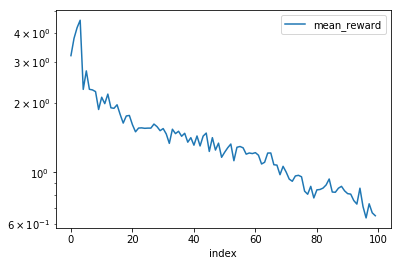

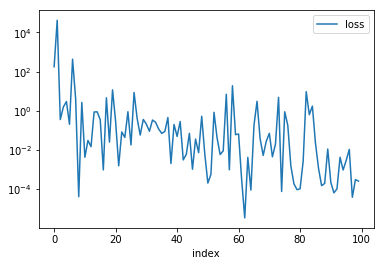

In [117]:
res = pd.DataFrame(hist, columns=('mean_reward', 'loss')).reset_index()
res.plot('index', 'mean_reward', logy=True)
res.plot('index', 'loss', logy=True)

awesome

we can try building a real neural network, then! for simplicity, we ignore the layer type, since we test on a very simple problem, and use only fully connected layers.

we create 10 independent and normally distributed features, and compute the output using only two of them. this creates high risk of overfitting, because random networks are too big and do not generalize. in fact, a simple network with one hidden layer of 5 neurons easily achieves 0.001 validation mse, whereas a 4 hidden layers network overfits and gets stuck at 0.2

In [118]:
def target_function(x, y):
    return np.sin(x) * np.cos(y)# + np.random.normal(scale=0.001, size=len(x))

data_x = np.random.normal(size=(100, 10))
data_y = target_function(data_x[:, 0], data_x[:, 1])

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2)

In [119]:
class SimpleFCNetwork:
    def __init__(self):
        self.learning_rate = 0.1

    def make_weights(self, rows, cols, mag=0.1):
        weights = tf.Variable(tf.random_uniform([rows, cols], -mag, mag))
        bias = tf.Variable(tf.constant(mag * (2 * np.random.random() - 1), shape=[1, cols]))
        self.variables.append(weights)
        self.variables.append(bias)
        return weights, bias

    @staticmethod
    def compute_next_layer(input_layer, weights, bias, activation=tf.nn.relu):
        h = tf.matmul(input_layer, weights) + bias
        output = activation(h) if activation else tf.identity(h)
        return output

    def build(self, input_shape, layers):
        self.input = tf.placeholder(tf.float32, [None, input_shape])
        self.label = tf.placeholder(tf.float32, [None, 1])

        self.variables = []
        last_layer, last_size = self.input, input_shape
        for layer_type, layer_arg in layers:
            if layer_type <= 1:
                ws, bs = self.make_weights(last_size, layer_arg)
                last_layer = self.compute_next_layer(last_layer, ws, bs)
                last_size = layer_arg
            else:
                last_layer = tf.nn.dropout(
                    last_layer, keep_prob=(layer_arg + 1) / 11
                )

        ws, bs = self.make_weights(last_size, 1)
        self.output = self.compute_next_layer(last_layer, ws, bs, activation=None)
        self.loss = tf.reduce_mean(tf.squared_difference(self.output, self.label))
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.optimize = optimizer.minimize(self.loss)
        
        return self

    def train_on_batch(self, sess, batch_x, batch_y):
        loss, _ = sess.run([self.loss, self.optimize], feed_dict={
            self.input: batch_x,
            self.label: batch_y.reshape(-1, 1),
        })
        return loss

    def test_on_batch(self, sess, batch_x, batch_y):
        return sess.run(self.loss, feed_dict={
            self.input: batch_x,
            self.label: batch_y.reshape(-1, 1),
        })


def evaluate_architecture(sess, nnet, batch_size=10, max_epochs=100, verbose=0):
    for ep in range(max_epochs):
        # perform a full epoch on training data
        sh_train_x, sh_train_y = shuffle(train_x, train_y)
        for batch_start in range(0, train_x.shape[0], batch_size):
            ll = nnet.train_on_batch(
                sess,
                sh_train_x[batch_start:batch_start + batch_size],
                sh_train_y[batch_start:batch_start + batch_size],
            )
        
        # evaluate on test data
        val_err = np.mean([
            nnet.test_on_batch(
                sess,
                test_x[batch_start:batch_start + batch_size],
                test_y[batch_start:batch_start + batch_size],
            ) for batch_start in range(0, test_x.shape[0], batch_size)
        ])
        
        if verbose > 0:
            print(ep, val_err)
    
    return val_err


with tf.Graph().as_default():
    small_nnet = SimpleFCNetwork().build(train_x.shape[1], [(1, 5)])
    large_nnet = SimpleFCNetwork().build(train_x.shape[1], [(1, 10) for i in range(10)])
    
    with tf.Session() as sess:
        initializer = tf.global_variables_initializer()
        sess.run(initializer)

        print('small network', evaluate_architecture(sess, small_nnet))
        print('large network', evaluate_architecture(sess, large_nnet))

small network 0.15526232
large network 0.22991323


In [120]:
class MovingAverages:
    def __init__(self):
        self.metrics = {}
        self.smoothing = {}
        self.snapshots = []
    
    def update(self, metric, value, smoothing=None):
        if smoothing is None:
            smoothing = self.smoothing.get(metric, 0.6)
        self.smoothing[metric] = smoothing
        
        # can pass None to update smoothing
        if value is not None:
            self.metrics[metric] = (
                smoothing * self.metrics.get(metric, value)
                + (1 - smoothing) * value
            )
        return self.metrics[metric]
    
    def update_all(self, **metrics):
        for metric, value in metrics.items():
            self.update(metric, value)
        return [self.metrics[m] for m in metrics]
    
    def snapshot(self, **meta):
        snap = dict(self.metrics)
        snap.update(meta)
        self.snapshots.append(snap)
        return snap

In [ ]:
class Logger:
    def __init__(self):
        self.averages = MovingAverages()
        self.averages.smoothing['time'] = 0
        self.start_time = None
        
    def __call__(self, step, networks, rewards, loss):
        if self.start_time is None:
            self.start_time = time.time()

        self.averages.update_all(
            contro_loss=loss**2,
            inner_mse=np.mean(rewards),
            inner_mse_std=np.std(rewards),
            length=np.mean(list(map(len, networks))),
            size=np.mean([sum(n for _, n in arch) for arch in networks]),
        )

        if step % 25 == 0:
            snap = self.averages.snapshot(i=step, time=time.time() - self.start_time)
            print('  '.join(
                '%s=%.3f' % metric for metric in snap.items()
            ))


def evaluate_architectures(architectures):
    # test architectures on a temporary graph and session
    with tf.Graph().as_default():
        networks = [
            SimpleFCNetwork().build(train_x.shape[1], arch)
            for arch in architectures
        ]

        with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
            sess.run(tf.global_variables_initializer())
            rewards = [
                evaluate_architecture(
                    sess, nnet, verbose=0
                ) for nnet in networks
            ]
            
    return rewards


logger = Logger()


run_rl_nas(
    spark_context=None,
    eval_fn=evaluate_architectures,
    max_len=10,
    batch_size=2,
    type_count=2,
    arg_count=10,
    max_steps=10000,
    end_fn=logger,
    controller_lr=0.001,
    hidden_size=32,
    baseline_smoothing=0.99,
)     

clear_output()

contro_loss=2.423  inner_mse=0.269  inner_mse_std=0.072  length=4.029  size=24.169  i=25.000  time=45.479
contro_loss=0.410  inner_mse=0.162  inner_mse_std=0.058  length=1.805  size=9.094  i=50.000  time=86.580


In [ ]:
res = pd.DataFrame(logger.averages.snapshots)
res.plot('i', 'inner_mse', logy=True, yerr='inner_mse_std')
res.plot('i', 'contro_loss', logy=True)

soooo cool